In [5]:
import requests

# URL al contenido bruto del archivo
base_url = "https://raw.githubusercontent.com/Jorgellamocca/WRF/main/datos_wrf_out/"
file_names = [

    "wrfout_d02_2024-11-24_01:00:00",
    "wrfout_d02_2024-11-24_02:00:00"
]

# Descargar los archivos
for file_name in file_names:
    file_url = f"{base_url}{file_name}"
    local_file = f"./{file_name}"
    try:
        response = requests.get(file_url, stream=True)
        if response.status_code == 200:
            with open(local_file, "wb") as f:
                f.write(response.content)
            print(f"Archivo descargado exitosamente: {local_file}")
        else:
            print(f"Error al descargar el archivo {file_name}: {response.status_code}")
    except Exception as e:
        print(f"Error durante la descarga del archivo {file_name}: {e}")



Archivo descargado exitosamente: ./wrfout_d02_2024-11-24_01:00:00
Archivo descargado exitosamente: ./wrfout_d02_2024-11-24_02:00:00


In [9]:
!pip install cartopy
!conda install -c conda-forge netcdf4

!pip install h5netcdf





/bin/bash: line 1: conda: command not found


In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Rutas de los archivos WRF
file_current = "./wrfout_d02_2024-11-24_01:00:00"
file_previous = "./wrfout_d02_2024-11-24_02:00:00"

try:
    # Cargar los archivos WRF con el motor adecuado
    ds_current = xr.open_dataset(file_current, engine="netcdf4")
    ds_previous = xr.open_dataset(file_previous, engine="netcdf4")

    # Validar si las variables de precipitación están disponibles
    if "RAINNC" not in ds_current.variables or "RAINC" not in ds_current.variables:
        raise ValueError("Variables RAINNC o RAINC no encontradas en los archivos.")

    # Calcular el acumulado total de precipitación en ambos tiempos
    precip_total_current = ds_current["RAINNC"] + ds_current["RAINC"]
    precip_total_previous = ds_previous["RAINNC"] + ds_previous["RAINC"]

    # Calcular el acumulado horario
    precip_hourly = precip_total_current - precip_total_previous

    # Crear el gráfico con Cartopy
    fig, ax = plt.subplots(
        figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    # Graficar el acumulado horario con el colormap nipy_spectral
    mesh = ax.pcolormesh(
        ds_current["XLONG"].isel(Time=0),
        ds_current["XLAT"].isel(Time=0),
        precip_hourly.isel(Time=0),
        cmap="nipy_spectral",
        transform=ccrs.PlateCarree(),  # Transformación a coordenadas geográficas
    )
    plt.colorbar(mesh, ax=ax, orientation="horizontal", label="Precipitación horaria (mm)")

    # Añadir detalles al mapa
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="gray")
    ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    ax.set_title("Acumulado Horario de Precipitación - Colormap nipy_spectral")
    plt.show()

except Exception as e:
    print(f"Error: {e}")


Error: unrecognized engine netcdf4 must be one of your download engines: ['h5netcdf', 'scipy', 'store']To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html


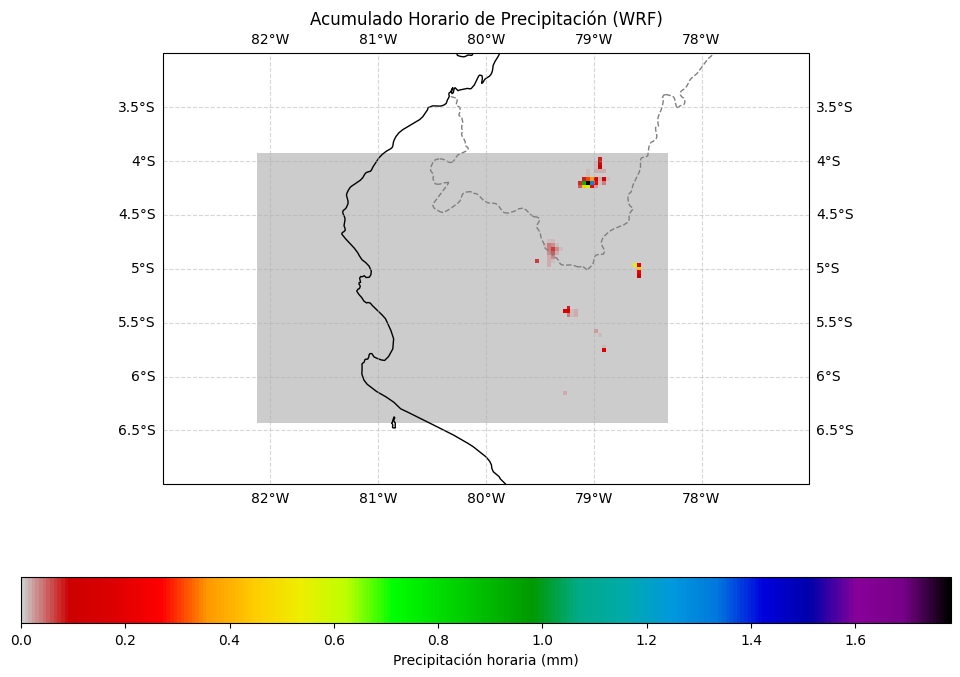

In [24]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Rutas de los archivos WRF
file_previous = "./wrfout_d02_2024-11-24_01:00:00"
file_current = "./wrfout_d02_2024-11-24_02:00:00"

# Leer los archivos WRF
ds_previous = xr.open_dataset(file_previous, engine="h5netcdf")
ds_current = xr.open_dataset(file_current, engine="h5netcdf")

# Calcular acumulado horario
precip_total_previous = ds_previous["RAINNC"] + ds_previous["RAINC"]
precip_total_current = ds_current["RAINNC"] + ds_current["RAINC"]
precip_hourly = precip_total_current - precip_total_previous

# Extraer latitudes y longitudes
lat = ds_current["XLAT"].isel(Time=0)
lon = ds_current["XLONG"].isel(Time=0)

# Crear el gráfico con Cartopy
fig, ax = plt.subplots(
    figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Graficar el acumulado horario
mesh = ax.pcolormesh(
    lon,
    lat,
    precip_hourly.isel(Time=0),
    cmap="nipy_spectral_r",
    transform=ccrs.PlateCarree()  # Transformar desde coordenadas geográficas
)

# Añadir barra de colores
plt.colorbar(mesh, ax=ax, orientation="horizontal", label="Precipitación horaria (mm)")

# Añadir características al mapa
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="gray")
ax.set_extent([-83, -77, -7, -3], crs=ccrs.PlateCarree())  # Extensión ajustada a los datos
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
ax.set_title("Acumulado Horario de Precipitación (WRF)")
plt.show()

